# LGBM을 활용한 베이스라인

In [4]:
import pandas as pd
import os
import random

import os
import time
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import random
from collections import defaultdict

import multiprocessing
from functools import partial
import parmap
from datetime import datetime

In [2]:
!pip install parmap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 데이터 로딩

In [5]:
data_dir = '/content/drive/MyDrive/DKT/eda_code'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [6]:
def generate_mean_std(df, df_all, x):
    x_mean = df_all.groupby(x)['answerCode'].mean().reset_index()
    x_std = df_all.groupby(x)['answerCode'].std().reset_index()

    x_mean = {key:value for key, value in x_mean.values}
    x_std = {key:value for key, value in x_std.values}

    df_mean = df[x].apply(lambda x: x_mean[x])
    df_std = df[x].apply(lambda x: x_std[x])

    return df_mean, df_std

In [7]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_t.columns = ["test_mean", 'test_sum', 'test_std']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum', 'std'])
    correct_k.columns = ["tag_mean", 'tag_sum', 'tag_std']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    grouped = df.groupby(df.userID)
    final_df = sorted(list(df['userID'].unique()))
    final_df = parmap.map(partial(process_by_userid, grouped = grouped), 
                                  final_df, pm_pbar = True, pm_processes = multiprocessing.cpu_count())
    df = pd.concat(final_df)

    # 문제 난이도 추가
    test = pd.read_csv(os.path.join('/content/drive/MyDrive/DKT/eda_code', 'test_data.csv')) 
    test['difficulty'] = test['assessmentItemID'].apply(lambda x:x[1:4])
    diff_rate = test.loc[test.answerCode!=-1].groupby('difficulty').mean().reset_index()
    diff_rate = diff_rate[['difficulty','answerCode']]
    diff_rate = {key:value for key, value in diff_rate.values}

    # df['difficulty'] = df['assessmentItemID'].apply(lambda x:x[1:4])
    # if self.args.mode =='inference':
    #     diff_rate = df.loc[df.answerCode!=-1].groupby('difficulty').mean().reset_index()
    # elif self.args.mode == 'train':
    #     diff_rate = df.groupby('difficulty').mean().reset_index()
    # diff_rate = diff_rate[['difficulty','answerCode']]
    # diff_rate = {key:value for key, value in diff_rate.values}

    df['difficulty'] = df['assessmentItemID'].apply(lambda x:x[1:4])
    df['difficulty'] = df['difficulty'].apply(lambda x: diff_rate[x])
    df['difficulty_mean'], df['difficulty_std'] = generate_mean_std(df, df, 'difficulty')
    
    df['assId_mean'], df['assId_std'] = generate_mean_std(df, df, 'assessmentItemID')

    return df

In [8]:
def get_character(x):
    if x < 0:
        return 'A'
    elif x < 23:
        return 'B'
    elif x < 56:
        return 'C'
    elif x < 68:
        return 'D'
    elif x < 84:
        return 'E'
    elif x < 108:
        return 'F'
    elif x < 4*60:
        return 'G'
    elif x < 24*60*60:
        return 'H'
    else :
        return 'I'

In [9]:
def convert_time(s):
    timestamp = datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple()
    return timestamp

In [10]:
def process_by_userid(x, grouped): # junho
    gp = grouped.get_group(int(x))
    gp = gp.sort_values(by=['userID','Timestamp'] ,ascending=True)
    tmp = gp['Timestamp'].astype(str)
    gp['Timestamp'] = tmp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    gp['time'] = gp['Timestamp'].shift(-1, fill_value=datetime.strptime('1970-01-01 00:00:00', '%Y-%m-%d %H:%M:%S'))
    gp['time'] = gp['time'] - gp['Timestamp']
    gp['time'] = gp['time'].apply(lambda x:int(x.total_seconds()))
    gp['duration'] = gp['time'].apply(lambda x: x if x >= 0 else gp['time'][(gp['time'] <= 4*60) & (gp['time'] >= 0)].mean())
    gp['character'] = gp['time'].apply(get_character)

    timetuple = tmp.apply(convert_time)
    gp['week_number'] = gp['Timestamp'].apply(lambda x:x.isocalendar()[1]) # 해당 년도의 몇번째 주인지
    gp['mday'] = timetuple.apply(lambda x:x.tm_wday) # 요일
    gp['hour'] = timetuple.apply(lambda x:x.tm_hour) # 시간
    
    # 문제 푼 수(전체, 태그별, 시험지별), 이동평균(전체, 태그별, 시험지별)
    record = defaultdict(int)
    gp['total_solved'], gp['tag_solved'], gp['testid_solved']  = 0, 0, 0
    gp['total_avg'], gp['tag_avg'], gp['testid_avg']  = 0, 0, 0
    total_avg, tag_avg, testid_avg, total_solved, tag_solved, testid_solved, flag = [], [], [], [], [], [], 0
    for i in range(len(gp)):
        if gp['time'].iloc[i] > 30*24*60*60:
            flag = 1
        elif flag == 1:
            record, flag = defaultdict(int), 0

        total_avg.append(float(round((record['total_correct']/record['total_solved'])*100, 2)) if record['total_solved'] != 0 else 0)
        tag_avg.append(float(round((record[str(gp['KnowledgeTag'].iloc[i])+'cor']/record[gp['KnowledgeTag'].iloc[i]])*100, 2)) if record[gp['KnowledgeTag'].iloc[i]] != 0 else 0)
        testid_avg.append(float(round((record[str(gp['testId'].iloc[i])+'cor']/record[gp['testId'].iloc[i]])*100,2)) if record[gp['testId'].iloc[i]] != 0 else 0)

        total_solved.append(record['total_solved'])
        record['total_solved'] += 1

        tag_solved.append(record[gp['KnowledgeTag'].iloc[i]])
        record[gp['KnowledgeTag'].iloc[i]] += 1

        testid_solved.append(record[gp['testId'].iloc[i]])
        record[gp['testId'].iloc[i]] += 1

        if gp['answerCode'].iloc[i] == 1:
            record['total_correct'] += 1
            record[str(gp['KnowledgeTag'].iloc[i])+'cor'] += 1
            record[str(gp['testId'].iloc[i])+'cor'] += 1

    gp['total_solved'], gp['tag_solved'], gp['testid_solved']  = total_solved, tag_solved, testid_solved
    gp['total_avg'], gp['tag_avg'], gp['testid_avg']  = total_avg, tag_avg, testid_avg
    return gp

In [11]:
def use_all(dt, max_seq_len, slide):
    seq_len = len(dt[0])
    tmp = np.stack(dt)
    new =[tuple([np.array(j) for j in tmp[:,i:i+max_seq_len]]) for i in range(0, seq_len, max_seq_len//slide)]
    # new=[]
    # for i in range(0, seq_len, max_seq_len//slide):
    #     check = tuple([np.array(j) for j in tmp[:,i:i+max_seq_len]])
    #     new.append(check)
    return new

In [12]:
df = feature_engineering(df)
df.head()

6704it [08:51, 12.62it/s]


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,test_std,tag_mean,tag_sum,tag_std,time,duration,character,week_number,mday,hour,total_solved,tag_solved,testid_solved,total_avg,tag_avg,testid_avg,difficulty,difficulty_mean,difficulty_std,assId_mean,assId_std
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.222749,0.955022,637,0.207410,3,3.0,B,13,1,0,0,0,0,0.0,0.0,0.0,0.737582,0.709232,0.454118,0.982063,0.133022
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,1268,0.222749,0.913187,3040,0.281603,8,8.0,B,13,1,0,1,0,1,100.0,0.0,100.0,0.737582,0.709232,0.454118,0.964126,0.186395
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,1268,0.222749,0.913187,3040,0.281603,7,7.0,B,13,1,0,2,1,2,100.0,100.0,100.0,0.737582,0.709232,0.454118,0.910314,0.286374
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,1268,0.222749,0.913187,3040,0.281603,7,7.0,B,13,1,0,3,2,3,100.0,100.0,100.0,0.737582,0.709232,0.454118,0.968610,0.174762
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,1268,0.222749,0.913187,3040,0.281603,11,11.0,B,13,1,0,4,3,4,100.0,100.0,100.0,0.737582,0.709232,0.454118,0.941704,0.234829


In [28]:
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')


## 3. Train/Test 데이터 셋 분리

In [29]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [30]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
       'test_mean', 'test_sum', 'test_std', 'tag_mean', 'tag_sum', 'tag_std',
       'time', 'duration', 'character', 'week_number', 'mday', 'hour',
       'total_solved', 'tag_solved', 'testid_solved', 'total_avg', 'tag_avg',
       'testid_avg', 'difficulty', 'difficulty_mean', 'difficulty_std',
       'assId_mean', 'assId_std'],
      dtype='object')

In [31]:
category_type_columns = ['KnowledgeTag', 'week_number', 'mday', 'hour']
for cat in category_type_columns:
    df[cat] = df[cat].astype('category')


In [57]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
#FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum']

# all features (80.64%):
#FEATS = ['userID', 'assessmentItemID', 'testId', 
#       'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
#       'test_mean', 'test_sum', 'tag_mean', 'tag_sum', 'time', 'duration',
#       'character', 'week_number', 'mday', 'hour', 'total_solved',
#       'tag_solved', 'testid_solved', 'total_avg', 'tag_avg', 'testid_avg',
#       'difficulty']

# all features - user_total_answer (79.94%)
#FEATS = ['userID', 'assessmentItemID', 'testId', 
#       'KnowledgeTag', 'user_correct_answer', 'user_acc',
#       'test_mean', 'test_sum', 'tag_mean', 'time', 'duration',
#       'character', 'week_number', 'mday', 'hour', 'total_solved',
#       'tag_solved', 'testid_solved', 'total_avg', 'tag_avg', 'testid_avg',
#       'difficulty']

# all features - user_total_answer, tag_mean, test_sum, m_day (79.35%)
#FEATS = ['userID', 'assessmentItemID', 'testId', 
#       'KnowledgeTag', 'user_correct_answer', 'user_acc',
#       'test_mean', 'time', 'duration',
#       'character', 'week_number', 'hour', 'total_solved',
#       'tag_solved', 'testid_solved', 'total_avg', 'tag_avg', 'testid_avg',
#       'difficulty']

# all features - user_total_answer, tag_sum, KnowledgeTag (80.14%)
#FEATS = ['userID', 'assessmentItemID', 'testId', 
#       'user_correct_answer', 'user_acc',
#       'test_mean', 'test_sum', 'tag_mean', 'time', 'duration',
#       'character', 'week_number', 'mday', 'hour', 'total_solved',
#       'tag_solved', 'testid_solved', 'total_avg', 'tag_avg', 'testid_avg',
#       'difficulty']

# 80.92%
# FEATS = ['userID', 'assessmentItemID', 'testId',
#        'user_correct_answer', 'user_total_answer', 'user_acc',
#        'test_mean', 'test_sum', 'duration',
#        'character', 'week_number', 'mday', 'hour', 'total_solved',
#        'tag_solved', 'testid_solved', 'total_avg', 'tag_avg', 'testid_avg']

# 80.84%
# FEATS = ['userID', 'assessmentItemID', 'testId', 
#        'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
#        'test_mean', 'test_sum', 'test_std', 'tag_mean', 'tag_sum', 'tag_std',
#        'time', 'duration', 'character', 'week_number', 'mday', 'hour',
#        'total_solved', 'tag_solved', 'testid_solved', 'total_avg', 'tag_avg',
#        'testid_avg', 'difficulty', 'difficulty_mean', 'difficulty_std',
#        'assId_mean', 'assId_std']

# 81.50%
# FEATS = ['userID', 'assessmentItemID', 'testId', 
#        'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
#        'test_mean', 'test_sum', 'test_std', 'tag_sum', 'tag_std',
#        'time', 'duration', 'character', 'hour',
#        'total_solved', 'tag_solved', 'testid_solved', 'total_avg', 'tag_avg',
#        'testid_avg', 'difficulty', 'difficulty_mean',
#        'assId_mean', 'assId_std']


# 81.53%
# FEATS = ['userID', 'assessmentItemID', 'testId', 
#        'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
#        'test_mean', 'test_std', 'tag_sum',
#        'time', 'duration', 'character', 'hour',
#        'total_solved', 'tag_solved', 'testid_solved', 'total_avg', 'tag_avg',
#        'testid_avg', 'difficulty', 'difficulty_mean',
#        'assId_mean', 'assId_std']

# FEATS = ['userID', 'assessmentItemID', 'testId', 
#        'KnowledgeTag', 'user_correct_answer', 'user_total_answer', 'user_acc',
#        'test_mean', 'test_std',
#        'time', 'duration', 'character', 'hour',
#        'total_solved', 'tag_solved', 'testid_solved', 'total_avg', 'tag_avg',
#        'testid_avg', 'difficulty', 'difficulty_mean',
#        'assId_mean', 'assId_std']


# 80.84%
FEATS = ['userID', 'assessmentItemID', 'testId', 
       'KnowledgeTag', 'user_acc',
       'test_mean', 'test_std', 'tag_mean', 'tag_std',
       'duration', 'character', 'week_number', 'mday', 'hour',
       'difficulty', 'difficulty_mean', 'difficulty_std',
       'assId_mean', 'assId_std']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [33]:
!pip install lightgbm

In [34]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [58]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [59]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=2000,
                    early_stopping_rounds=100
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.440029	valid_1's binary_logloss: 0.542245
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.440284	valid_1's binary_logloss: 0.542181
VALID AUC : 0.7992858994818162 ACC : 0.722673031026253



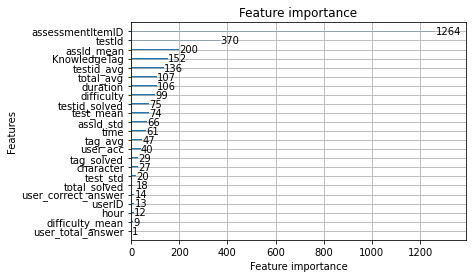

In [60]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [50]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in test_df.columns:
    col_type = test_df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        test_df[c] = test_df[c].astype('category')
        
category_type_columns = ['KnowledgeTag', 'week_number', 'mday', 'hour']
for cat in category_type_columns:
    test_df[cat] = test_df[cat].astype('category')

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

100%|██████████| 744/744 [00:55<00:00, 13.50it/s]


In [51]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [52]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "output.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/output.csv
